<a href="https://colab.research.google.com/github/RufusRubin/KNUCKLE_CLASSIFICATION/blob/main/RESNET_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm


! pip install torchview
! pip install graphviz

In [ ]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
from imutils import paths
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pretrainedmodels
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import models

from torchview import draw_graph
import graphviz


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
root='/kaggle/input/knuckle-dataset/knuckle_datset-20220916T075635Z-001/knuckle_dataset'

In [ ]:
classes=('001', '002', '003', '004', '005', '006', '007', '008', '009','010', '011', '012', '013', '014', '015', '016', '017', '018','019', '020', '021', '022', '023', '024', '025', '026', '027','028', '029', '030', '031', '032', '033', '034', '035', '036','037', '038', '039', '040', '041', '042', '043', '044', '045','046', '047', '048', '049', '050', '051', '052', '053', '054','055', '056', '057', '058', '059', '060', '061', '062', '063','064', '065', '066', '067', '068', '069', '070', '071', '072','073', '074', '075', '076', '077', '078', '079', '080', '081','082', '083', '084', '085', '086', '087', '088', '089', '090','091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117','118', '119', '120', '121', '122', '123', '124', '125', '126','127', '128', '129', '130', '131', '132', '133', '134', '135','136', '137', '138', '139', '140', '141', '142', '143', '144','145', '146', '147', '148', '149', '150', '151', '152', '153','154', '155', '156', '157', '158')


In [ ]:
image_paths = list(paths.list_images('/kaggle/input/knuckle-dataset/knuckle_datset-20220916T075635Z-001/knuckle_dataset'))

data = []
labels = []
for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [ ]:
labels

array(['135', '135', '135', '135', '135', '057', '057', '057', '057',
       '057', '086', '086', '086', '086', '086', '121', '121', '121',
       '121', '121', '061', '061', '061', '061', '061', '048', '048',
       '048', '048', '048', '053', '053', '053', '053', '053', '147',
       '147', '147', '147', '147', '145', '145', '145', '145', '145',
       '051', '051', '051', '051', '051', '137', '137', '137', '137',
       '137', '095', '095', '095', '095', '095', '018', '018', '018',
       '018', '018', '044', '044', '044', '044', '044', '016', '016',
       '016', '016', '016', '007', '007', '007', '007', '007', '009',
       '009', '009', '009', '009', '012', '012', '012', '012', '012',
       '029', '029', '029', '029', '029', '025', '025', '025', '025',
       '025', '078', '078', '078', '078', '078', '001', '001', '001',
       '001', '001', '056', '056', '056', '056', '056', '006', '006',
       '006', '006', '006', '120', '120', '120', '120', '120', '109',
       '109', '109',

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 158


In [ ]:
#orginal dataset

train_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])    


#for data augmentation

train_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
# divide the data into train, validation, and test set
#(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
#(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
#print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3,stratify=labels, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

x_train examples: (553, 100, 80, 3)
x_test examples: (237, 100, 80, 3)


In [ ]:
batch_size=6

In [ ]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        labels = self.labels[index]
        
        if self.transforms:
            data = self.transforms(data)
            
            return data,labels

        
        
        
        
train_orginal_data = CustomDataset(x_train, y_train, train_orginal_transforms)
test_orginal_data = CustomDataset(x_test, y_test, test_orginal_transforms)     


train_augmentation_data = CustomDataset(x_train, y_train, train_augmentation_transforms )
test_augmentation_data = CustomDataset(x_test, y_test, test_augmentation_transforms )  

train_data = torch.utils.data.ConcatDataset([train_orginal_data,train_augmentation_data])
print(len(train_data))
test_data = torch.utils.data.ConcatDataset([test_orginal_data,test_augmentation_data])
print(len(test_data))




trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory= True)
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory= True) 

1106
474


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for X, y in trainLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([6, 3, 224, 224])
Shape of y: torch.Size([6]) torch.int64


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **MODEL**

In [ ]:
original_model = models.resnet50(pretrained=True)
original_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# the vgg11 model
class ResNet50(nn.Module):
    def __init__(self, pretrained):
        super(ResNet50, self).__init__()

        
        self.model = nn.Sequential(*list(original_model.children())[:-2])
    
        # change the classification layer
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        #self.dropout = nn.Dropout2d(0.3)
        self.l0= nn.Linear(2048, len(lb.classes_))
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        
        x = self.model(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        #x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = ResNet50(pretrained=True).to(device)
print(model)

ResNet50(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet50(pretrained=True).to(device)

#model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location= device))

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

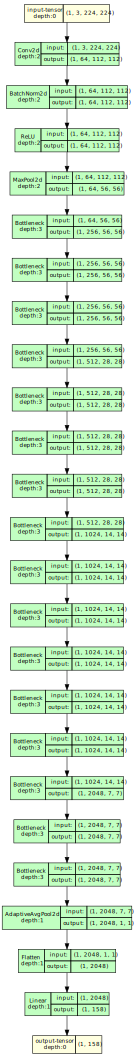

In [ ]:
model_plot = draw_graph(model, input_size=(1,3,224,224))
model_plot.visual_graph

# **OPTIMZER**

In [ ]:
lr = 0.001

WEIGHT_DECAY = 0.0005
save_path = "model.pth"
fine_tune = True
#load_path = "/kaggle/working/model_1.pth"

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)
optimizer= torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

# **LOAD MODEL**

In [ ]:
#state_dict = torch.load(load_path, map_location=device)
#model.load_state_dict(state_dict)

# **TRAINING**

In [ ]:
def train(model,trainloader):    
    # training function
    for epoch in range(epochs):
        print('Training')
        model.train()
        running_loss = 0.0
        running_correct = 0
        total=0
        for batch, (X, y) in enumerate(tqdm(trainloader)):


            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
               
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

        loss = running_loss/len(trainloader)
        accuracy = 100.*running_correct/total
        print('Train Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))
       

        #print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
        

        return loss, accuracy


# **VALIDATION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total=0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)
        
    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
    print('Test Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    return loss, accuracy

# **TRAINING AND VALIDATION IN SINGLE FUNCTION**

In [ ]:
epochs=50


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)


Training on 1106 examples, validating on 474 examples...
Epoch 1 of 50
Training


  0%|          | 0/185 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 185/185 [00:15<00:00, 12.08it/s]

Train Loss: 5.249 | Accuracy: 0.181
Validating


Test Loss: 5.103 | Accuracy: 1.477
Epoch 2 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.11it/s]

Train Loss: 4.964 | Accuracy: 3.165
Validating


Test Loss: 4.545 | Accuracy: 5.063
Epoch 3 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.10it/s]

Train Loss: 4.302 | Accuracy: 8.499
Validating


Test Loss: 3.640 | Accuracy: 15.612
Epoch 4 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.45it/s]

Train Loss: 3.579 | Accuracy: 18.716
Validating


Test Loss: 4.128 | Accuracy: 9.283
Epoch 5 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.20it/s]

Train Loss: 2.775 | Accuracy: 37.432
Validating


Test Loss: 2.271 | Accuracy: 45.781
Epoch 6 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.35it/s]

Train Loss: 2.020 | Accuracy: 59.403
Validating


Test Loss: 1.608 | Accuracy: 60.970
Epoch 7 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.07it/s]

Train Loss: 1.373 | Accuracy: 79.204
Validating


Test Loss: 0.853 | Accuracy: 86.709
Epoch 8 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.30it/s]

Train Loss: 0.969 | Accuracy: 88.246
Validating


Test Loss: 0.671 | Accuracy: 86.709
Epoch 9 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.20it/s]

Train Loss: 0.650 | Accuracy: 94.756
Validating


Test Loss: 0.481 | Accuracy: 91.983
Epoch 10 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.34it/s]

Train Loss: 0.451 | Accuracy: 96.564
Validating


Test Loss: 0.538 | Accuracy: 89.241
Epoch 11 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.34it/s]

Train Loss: 0.362 | Accuracy: 97.559
Validating


Test Loss: 0.265 | Accuracy: 95.992
Epoch 12 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.02it/s]

Train Loss: 0.277 | Accuracy: 98.734
Validating


Test Loss: 0.305 | Accuracy: 95.148
Epoch 13 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.32it/s]

Train Loss: 0.224 | Accuracy: 99.096
Validating


Test Loss: 0.513 | Accuracy: 90.717
Epoch 14 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 11.97it/s]

Train Loss: 0.176 | Accuracy: 99.367
Validating


Test Loss: 0.235 | Accuracy: 95.992
Epoch 15 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.23it/s]

Train Loss: 0.169 | Accuracy: 99.096
Validating


Test Loss: 0.237 | Accuracy: 95.992
Epoch 16 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.23it/s]

Train Loss: 0.146 | Accuracy: 99.458
Validating


Test Loss: 0.201 | Accuracy: 96.203
Epoch 17 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.26it/s]

Train Loss: 0.120 | Accuracy: 99.638
Validating


Test Loss: 0.220 | Accuracy: 96.414
Epoch 18 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.13it/s]

Train Loss: 0.102 | Accuracy: 99.819
Validating


Test Loss: 0.240 | Accuracy: 95.781
Epoch 19 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.25it/s]

Train Loss: 0.093 | Accuracy: 99.638
Validating


Test Loss: 0.225 | Accuracy: 95.992
Epoch 20 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.20it/s]

Train Loss: 0.086 | Accuracy: 99.910
Validating


Test Loss: 0.234 | Accuracy: 96.203
Epoch 21 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.30it/s]


Train Loss: 0.071 | Accuracy: 99.819
Validating
Test Loss: 0.205 | Accuracy: 95.570
Epoch 22 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.36it/s]

Train Loss: 0.073 | Accuracy: 99.910
Validating


Test Loss: 0.175 | Accuracy: 96.624
Epoch 23 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.15it/s]

Train Loss: 0.060 | Accuracy: 100.000
Validating


Test Loss: 0.196 | Accuracy: 96.414
Epoch 24 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.28it/s]

Train Loss: 0.075 | Accuracy: 99.638
Validating


Test Loss: 0.224 | Accuracy: 95.359
Epoch 25 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.18it/s]

Train Loss: 0.064 | Accuracy: 99.819
Validating


Test Loss: 0.200 | Accuracy: 95.992
Epoch 26 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.17it/s]

Train Loss: 0.049 | Accuracy: 99.910
Validating


Test Loss: 0.193 | Accuracy: 96.624
Epoch 27 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.21it/s]

Train Loss: 0.054 | Accuracy: 99.729
Validating


Test Loss: 0.192 | Accuracy: 96.835
Epoch 28 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.31it/s]

Train Loss: 0.051 | Accuracy: 99.819
Validating


Test Loss: 0.197 | Accuracy: 95.359
Epoch 29 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.06it/s]

Train Loss: 0.042 | Accuracy: 100.000
Validating


Test Loss: 0.183 | Accuracy: 95.992
Epoch 30 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.42it/s]

Train Loss: 0.043 | Accuracy: 100.000
Validating


Test Loss: 0.228 | Accuracy: 95.781
Epoch 31 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.06it/s]

Train Loss: 0.039 | Accuracy: 99.819
Validating


Test Loss: 0.218 | Accuracy: 95.992
Epoch 32 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.18it/s]

Train Loss: 0.053 | Accuracy: 99.548
Validating


Test Loss: 0.185 | Accuracy: 96.203
Epoch 33 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.30it/s]

Train Loss: 0.039 | Accuracy: 99.729
Validating


Test Loss: 0.213 | Accuracy: 95.992
Epoch 34 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.11it/s]

Train Loss: 0.045 | Accuracy: 99.819
Validating


Test Loss: 0.202 | Accuracy: 96.203
Epoch 35 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.29it/s]

Train Loss: 0.042 | Accuracy: 99.819
Validating


Test Loss: 0.180 | Accuracy: 96.624
Epoch 36 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.28it/s]

Train Loss: 0.034 | Accuracy: 100.000
Validating


Test Loss: 0.211 | Accuracy: 96.835
Epoch 37 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.41it/s]

Train Loss: 0.041 | Accuracy: 99.910
Validating


Test Loss: 0.217 | Accuracy: 95.992
Epoch 38 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.31it/s]

Train Loss: 0.029 | Accuracy: 100.000
Validating


Test Loss: 0.166 | Accuracy: 96.835
Epoch 39 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.22it/s]

Train Loss: 0.049 | Accuracy: 99.638
Validating


Test Loss: 0.159 | Accuracy: 97.257
Epoch 40 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.17it/s]

Train Loss: 0.037 | Accuracy: 99.910
Validating


Test Loss: 0.226 | Accuracy: 95.781
Epoch 41 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.35it/s]

Train Loss: 0.035 | Accuracy: 100.000
Validating


Test Loss: 0.195 | Accuracy: 96.835
Epoch 42 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.13it/s]

Train Loss: 0.039 | Accuracy: 99.729
Validating


Test Loss: 0.297 | Accuracy: 94.304
Epoch 43 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.27it/s]

Train Loss: 0.035 | Accuracy: 99.910
Validating


Test Loss: 0.209 | Accuracy: 96.835
Epoch 44 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.23it/s]

Train Loss: 0.031 | Accuracy: 99.819
Validating


Test Loss: 0.200 | Accuracy: 97.046
Epoch 45 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.17it/s]

Train Loss: 0.036 | Accuracy: 99.910
Validating


Test Loss: 0.177 | Accuracy: 96.624
Epoch 46 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.31it/s]

Train Loss: 0.035 | Accuracy: 99.910
Validating


Test Loss: 0.215 | Accuracy: 96.835
Epoch 47 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.18it/s]

Train Loss: 0.026 | Accuracy: 100.000
Validating


Test Loss: 0.175 | Accuracy: 96.835
Epoch 48 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.31it/s]

Train Loss: 0.028 | Accuracy: 99.910
Validating


Test Loss: 0.194 | Accuracy: 96.624
Epoch 49 of 50
Training


100%|██████████| 185/185 [00:15<00:00, 12.07it/s]

Train Loss: 0.024 | Accuracy: 100.000
Validating


Test Loss: 0.191 | Accuracy: 97.046
Epoch 50 of 50
Training


100%|██████████| 185/185 [00:14<00:00, 12.38it/s]

Train Loss: 0.027 | Accuracy: 100.000
Validating


Test Loss: 0.199 | Accuracy: 96.624


# **MODEL SAVING**

In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = ResNet50(pretrained=True).to(device)
#model.load_state_dict(torch.load("model.pth"))

state_dict = torch.load(f"/kaggle/working/{save_path}")
model.load_state_dict(state_dict)

<All keys matched successfully>

# **VISUALIZE PREDICTING IMAGE**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testLoader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    images=images.to(device)
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

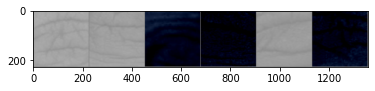

Real labels:    004   146   086   103   063   044
Predicted:    004   146   086   103   063   044


In [ ]:
testBatch()

# **PLOT ACCURACY**

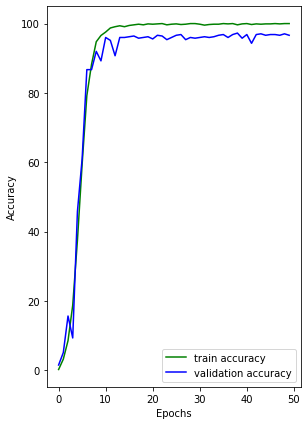

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/plots/accuracy.png')


# **PLOT LOSS**

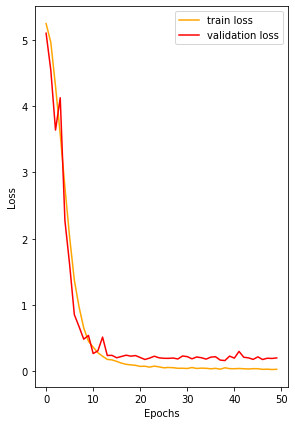

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

In [ ]:
label2class ={ 1 :'001', 2 :'002', 3:'003', 4:'004', 5:'005', 6:'006', 7:'007', 8:'008', 9:'009', 10:'010', 11:'011', 12:'012', 13:'013', 14:'014', 15:'015', 16:'016', 17:'017', 18:'018', 19:'019', 20:'020', 21:'021', 22:'022', 23:'023', 24:'024', 25:'025', 26:'026', 27:'027', 28:'028', 29:'029', 30:'030', 31:'031', 32:'032', 33:'033', 34:'034', 35:'035', 36:'036', 37:'037', 38:'038', 39:'039', 40:'040', 41:'041', 42:'042', 43:'043', 44:'044', 45:'045',46:'046', 47:'047', 48:'048', 49:'049', 50:'050', 51:'051', 52:'052', 53:'053', 54:'054',55:'055', 56:'056', 57:'057', 58:'058', 59:'059', 60:'060', 61:'061', 62:'062', 63:'063',64:'064', 65:'065', 66:'066', 67:'067', 68:'068', 69:'069', 70:'070', 71:'071', 72:'072',73:'073', 74:'074', 75:'075', 76:'076', 77:'077', 78:'078', 79:'079', 80:'080', 81:'081', 82:'082', 83:'083', 84:'084', 85:'085', 86:'086', 87:'087', 88:'088', 89:'089', 90:'090',91:'091', 92:'092', 93:'093', 94:'094', 95:'095', 96:'096', 97:'097', 98:'098', 99:'099', 100:'100', 101:'101', 102:'102', 103:'103', 104:'104', 105:'105', 106:'106', 107:'107', 108:'108', 109:'109', 110:'110', 111:'111', 112:'112', 113:'113', 114:'114', 115:'115', 116:'116', 117:'117',118:'118', 119:'119', 120:'120', 121:'121', 122:'122', 123:'123', 124:'124', 125:'125', 126:'126',127:'127', 128:'128', 129:'129', 130:'130', 131:'131', 132:'132', 133:'133', 134:'134', 135:'135',136:'136', 137:'137', 138:'138', 139:'139', 140:'140', 141:'141', 142:'142', 143:'143', 144:'144',145:'145', 146:'146', 147:'147', 148:'148', 149:'149', 150:'150', 151:'151', 152:'152', 153:'153',154:'154', 155:'155', 156:'156', 157:'157', 158:'158'}


In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for batch,(inputs, labels) in enumerate(testLoader):
    
    
        inputs= inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        

report = classification_report(y_true, y_pred)
print(report)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.80      1.00      0.89         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Text(0.5, 879.0, 'Predicted label')

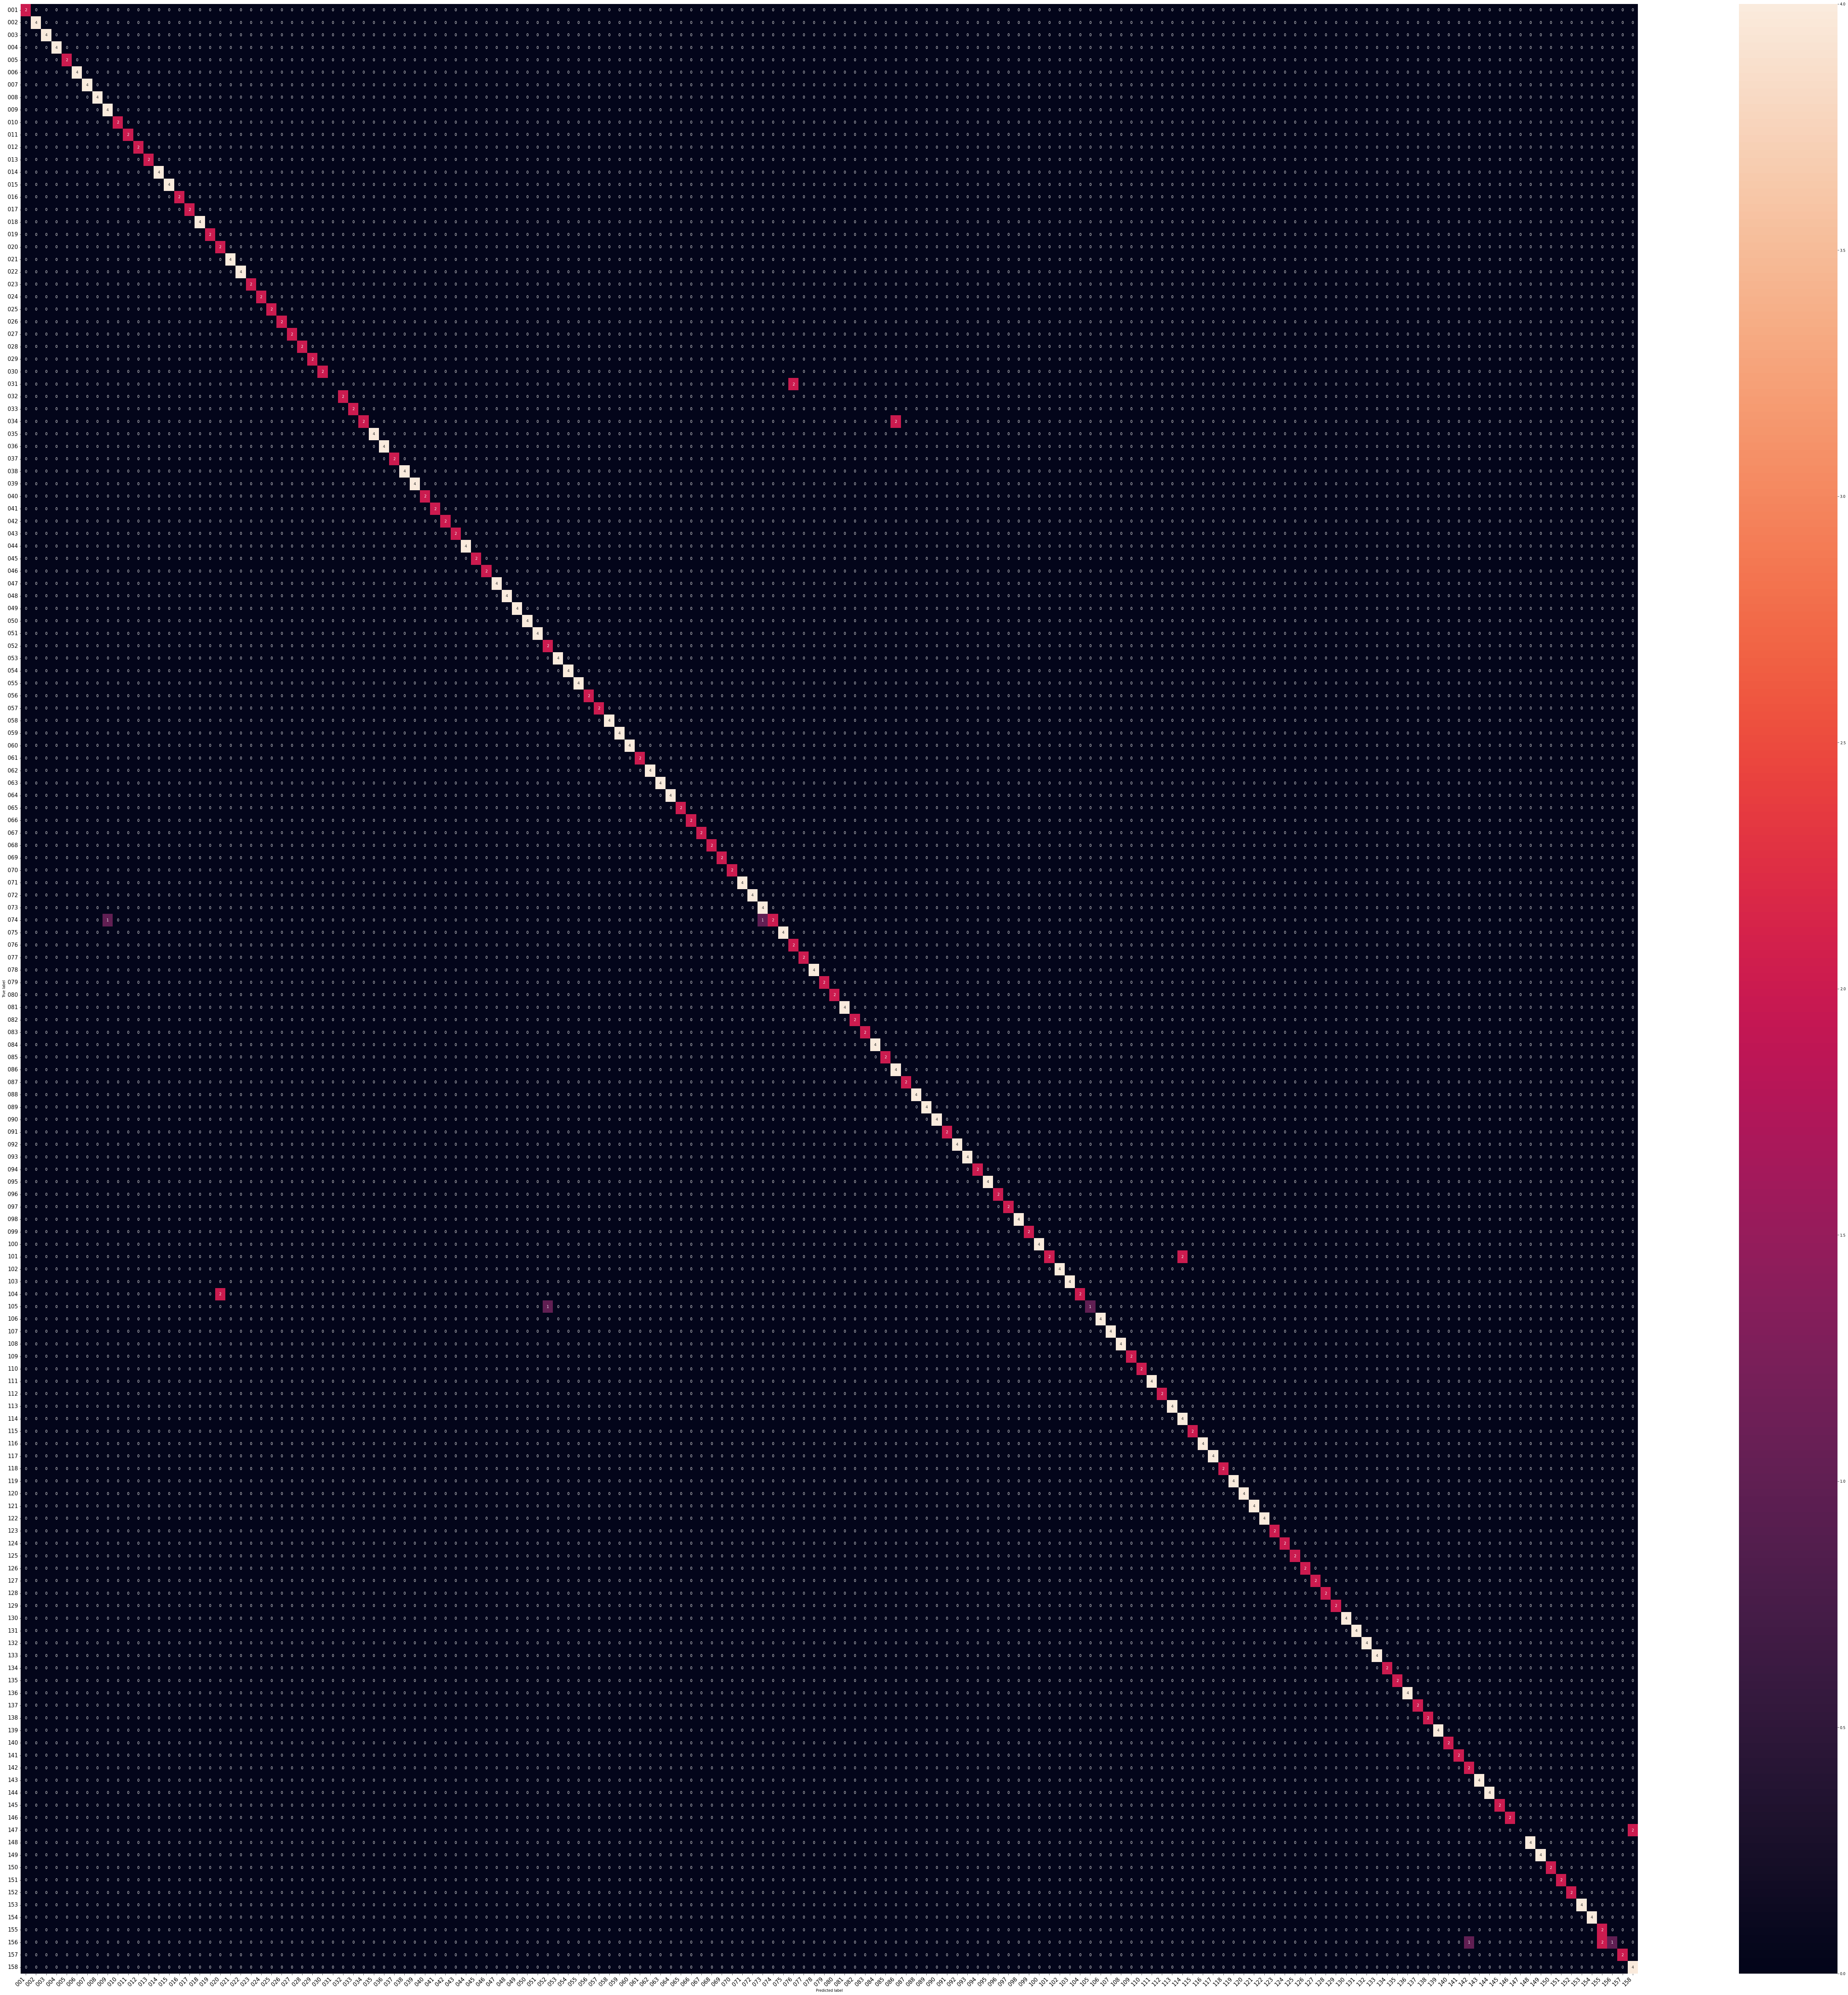

In [ ]:
nb_classes = 158
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(100,100))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')